### Dataset

In [136]:
import pickle

In [137]:
import pandas as pd
import numpy as np

In [138]:
izq = pickle.load(open('data/df_clean_izq.pkl','rb'))
izq['bias'] = 'left'
der = pickle.load(open('data/df_clean_der.pkl','rb'))
der['bias'] = 'right'

### Train Test Split

In [139]:
df = izq.loc[:,['body', 'bias']].append(der.loc[:,['body', 'bias']])

In [140]:
X = df.body; y = df.bias

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
train,test,y_train,y_test = train_test_split(X, y, train_size=0.75);
train.shape[0] / X.shape[0], test.shape[0] / X.shape[0]

(0.746268656716418, 0.2537313432835821)

### Folds config

In [143]:
from sklearn.model_selection import StratifiedKFold

In [144]:
folds = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)

### Vectorization, Transformation and Training

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import re

In [146]:
stopwords_sp = stopwords.words('spanish') + ['dia', 'fin','dias', 'dos', 'mas','ano', 'año', 'asi','puede', 'mes','incluso']

In [147]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

In [148]:
pipeline = Pipeline([
    ('cv', CountVectorizer(stop_words=stopwords_sp)),
    ('tfidf', TfidfTransformer()),
    ('sgdc', SGDClassifier()),
])

parameters = [
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'sgdc__penalty': ('l2', 'elasticnet', 'l1'),
        'sgdc__max_iter': [50, 80],
        'sgdc__tol': [1e-4],
        #'sgdc__loss': ['hinge', 'log', 'modified_huber'],
        'sgdc__loss': ['log', 'modified_huber'],
    },
]    

In [149]:
grid = GridSearchCV(pipeline, parameters, cv=folds, n_jobs=12, return_train_score=True, verbose=3)
grid.fit(train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    5.9s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   13.7s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   24.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   40.4s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1620 out of 1620 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
   

In [150]:
display(grid.best_params_, grid.best_score_)

{'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 2),
 'cv__preprocessor': <function __main__.removal(text)>,
 'cv__strip_accents': 'unicode',
 'sgdc__loss': 'modified_huber',
 'sgdc__max_iter': 50,
 'sgdc__penalty': 'l2',
 'sgdc__tol': 0.0001}

0.9800000000000001

### Testing and scores

In [151]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [152]:
grid.predict(test)

array(['right', 'left', 'right', 'left', 'right', 'left', 'right',
       'right', 'left', 'right', 'right', 'right', 'right', 'left',
       'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left',
       'left', 'right', 'left', 'left', 'right', 'right', 'right', 'left',
       'left', 'right', 'right', 'left'], dtype='<U5')

In [153]:
grid.predict_proba(test)

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.75816151, 0.24183849],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.49159666, 0.50840334],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.21866426, 0.78133574],
       [1.        , 0.        ],
       [1.

In [154]:
accuracy_score(y_test, grid.predict(test))

0.9411764705882353

In [155]:
confusion_matrix(y_test, grid.predict(test))

array([[15,  2],
       [ 0, 17]])

In [156]:
classification_report(grid.predict(test), y_test)

'              precision    recall  f1-score   support\n\n        left       0.88      1.00      0.94        15\n       right       1.00      0.89      0.94        19\n\n    accuracy                           0.94        34\n   macro avg       0.94      0.95      0.94        34\nweighted avg       0.95      0.94      0.94        34\n'

### Cloud from Grid
Vectorization with total corpus

In [157]:
cv = grid.best_estimator_['cv'].fit(df.body)

In [158]:
matrix = pd.DataFrame(cv.transform(X).todense(), columns = cv.vocabulary_)

In [159]:
matrix_izq = pd.DataFrame(cv.transform(df[df.bias == 'left'].body).todense(), columns = cv.vocabulary_)
matrix_der = pd.DataFrame(cv.transform(df[df.bias == 'right'].body).todense(), columns = cv.vocabulary_)

In [160]:
matrix_izq.sum().sort_values(ascending=False)[:10]

fortalecer             149
ampliamente            104
poseen                  84
paulo                   69
cualquier forma         67
dejó gobierno           61
costosa                 58
haciendo                58
omite                   54
posible capitalismo     52
dtype: int64

In [161]:
matrix_der.sum().sort_values(ascending=False)[:10]

poseen                   190
ampliamente              175
cualquier forma          161
fortalecer               144
aden                     131
congeladas gobierno      126
principios cuarentena    112
cierto afectará           99
motivos                   97
cobrado dólares           88
dtype: int64

In [162]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

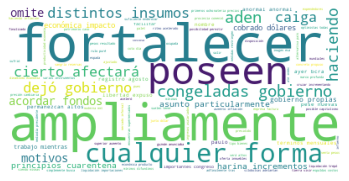

In [163]:
cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(matrix.sum())
plt.imshow(cloud)
plt.axis('off')

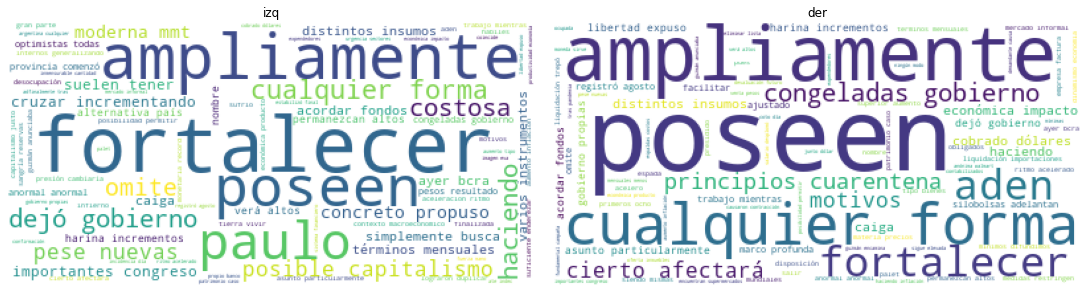

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,30))

cloud = WordCloud(background_color='white')

titles = ['izq', 'der']

for mx, ax, title in zip([matrix_izq, matrix_der], axes.flatten(), titles):
    cloud.generate_from_frequencies(mx.sum())
    ax.imshow(cloud)
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

### Cloud from new Vectorization

In [165]:
vectorizer = CountVectorizer(stop_words = stopwords_sp, lowercase = True, strip_accents='unicode', preprocessor=removal)
# vectorizer = CountVectorizer(stop_words = stopwords_sp, lowercase = True, strip_accents='unicode')

In [166]:
vectorizer.fit(X)

CountVectorizer(preprocessor=<function removal at 0x7f9d28084560>,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')

In [167]:
matrix_2 = pd.DataFrame(vectorizer.transform(X).todense(), columns = vectorizer.vocabulary_)
matrix_izq_2 = pd.DataFrame(vectorizer.transform(df[df.bias == 'left'].body).todense(), columns = vectorizer.vocabulary_)
matrix_der_2 = pd.DataFrame(vectorizer.transform(df[df.bias == 'right'].body).todense(), columns = vectorizer.vocabulary_)

In [168]:
matrix_izq_2.sum().sort_values(ascending=False)[:10]

capitales       149
ineficiencia    104
sincerar         84
enterrar         69
relativos        67
preocupación     61
congelar         58
impacto          58
remisión         54
emerge           52
dtype: int64

In [169]:
matrix_der_2.sum().sort_values(ascending=False)[:10]

sincerar         190
ineficiencia     175
relativos        161
capitales        144
casas            131
corporaciones    126
elevaría         112
exportar          99
premia            97
adaún             88
dtype: int64

(-0.5, 399.5, 199.5, -0.5)

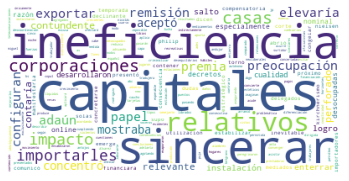

In [170]:
cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(matrix_2.sum())
plt.imshow(cloud)
plt.axis('off')

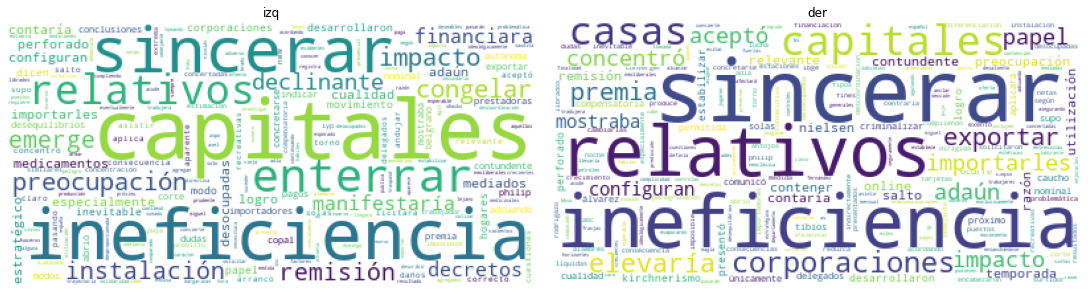

In [171]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,30))

cloud = WordCloud(background_color='white')

titles = ['izq', 'der']

for mx, ax, title in zip([matrix_izq_2, matrix_der_2], axes.flatten(), titles):
    cloud.generate_from_frequencies(mx.sum())
    ax.imshow(cloud)
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

#### Cloud with tf-idf

In [172]:
tfidf = TfidfTransformer().fit(matrix_2)

In [173]:
tfidf.transform(matrix_2)

<134x6549 sparse matrix of type '<class 'numpy.float64'>'
	with 23845 stored elements in Compressed Sparse Row format>

In [174]:
matrix_tfidf = pd.DataFrame(tfidf.transform(matrix_2).todense(), columns = vectorizer.vocabulary_)
matrix_izq_tfidf = pd.DataFrame(tfidf.transform(matrix_izq_2).todense(), columns = vectorizer.vocabulary_)
matrix_der_tfidf = pd.DataFrame(tfidf.transform(matrix_der_2).todense(), columns = vectorizer.vocabulary_)

(-0.5, 399.5, 199.5, -0.5)

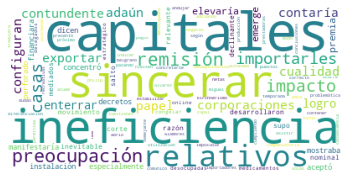

In [175]:
cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(matrix_tfidf.sum())
plt.imshow(cloud)
plt.axis('off')

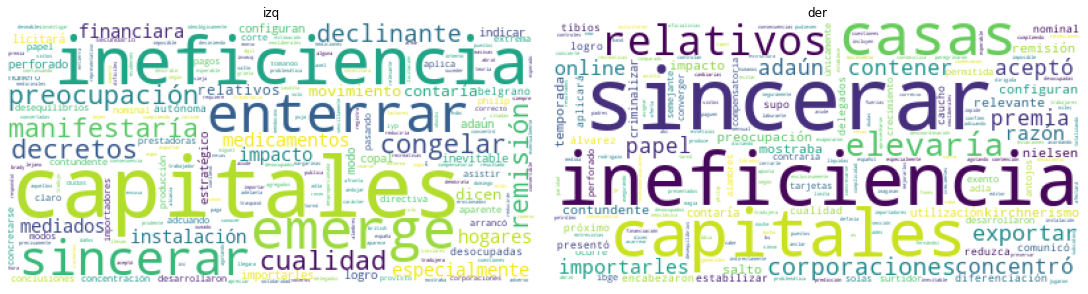

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,30))

cloud = WordCloud(background_color='white')

titles = ['izq', 'der']

for mx, ax, title in zip([matrix_izq_tfidf, matrix_der_tfidf], axes.flatten(), titles):
    cloud.generate_from_frequencies(mx.sum())
    ax.imshow(cloud)
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

### Pickle

In [177]:
import pickle

In [178]:
clf = grid.best_estimator_['sgdc']

In [179]:
with open('core/vectorizer.pkl', 'wb') as f:
    f.removal = removal
    vectorizer.fit(X)
    pickle.dump(vectorizer, f)
    
with open('core/classifier.pkl', 'wb') as f:
    clf.fit(matrix_2, y)
    pickle.dump(clf, f)

In [187]:
clf.fit(matrix_2, y)

SGDClassifier(loss='modified_huber', max_iter=50, tol=0.0001)

In [193]:
clf.predict_proba(vectorizer.transform(test))

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [196]:
test[1]

'La inflación de noviembre fue del 3,2\xa0% en comparación a octubre de 2020, mientras que respecto de noviembre de 2019 el aumento fue del 35,8\xa0%, según informó este martes el Indec. El rubro Alimentos y bebidas no alcohólicas subió en un año 40,4\xa0%, es decir por encima del nivel general. El organismo también indicó que el acumulado en el año es de 30,9\xa0%.La inflación núcleo, aquella que no incluye a los precios de productos o servicios estacionales y regulados, aceleró hasta 3,9\xa0% mensual; en octubre, había aumentado 3,5\xa0%.El organismo informó que la división Recreación y cultura fue la que mostró el mayor incremento en noviembre (5,1\xa0%), debido a la mayor apertura de actividades recreativas presenciales en gimnasios y alquiler de canchas. Sin embargo, la división Alimentos y bebidas no alcohólicas (2,7\xa0%) registró la mayor incidencia en todas las regiones. Se destacaron en este último caso las subas en Carnes y derivados; Frutas; y Aceites, grasas y manteca.En n